In [8]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [9]:
WINDOW_SIZE = 25
NUMBER_OF_FEATURES = 6
NUMBER_OF_CLASSES = 2


# Get the current working directory
CURRENT_DIRECTORY = os.getcwd()
# Get the parent directory
PARENT_DIRECTORY = os.path.dirname(CURRENT_DIRECTORY)


TEST_FILES_PATH = PARENT_DIRECTORY + '\\processed-training-data\\4-PROCESSED-DATA\TEST2\\'
TRAINING_FILES_PATH = PARENT_DIRECTORY + '\\processed-training-data\\4-PROCESSED-DATA\TRAIN2\\'

MODEL_FILE_PATH = CURRENT_DIRECTORY + "\\models\\lstm-1.h5"

SAVE_PREDICT_FILE_PATH = CURRENT_DIRECTORY + '\\PREDICT-LSTM-1.csv'

FILES_TO_PREDICT= [
    {"type": "test", "name": "PROC-TEST2-STEPS-LR-LAR-90BPM.xlsx"},
    {"type": "train", "name": "PROC-TRAIN2-STAND1.xlsx"},
    {"type": "test", "name": "PROC-TEST2-STEPS-LR-MED-100BPM.xlsx"},
]



In [10]:
def normalizeSensorData(sensor_input):
    if(sensor_input < 0):
        return np.abs(sensor_input/360)
    else:
        return 0.5 + np.abs(sensor_input/360)
    
# assume the range is from -8 to 8
def normalizeXVelocity(velocity_input):
    return ((velocity_input + 8)/16)

# assume thhe range from 0 to 8
def normalizeZVelocity(velocity_input):
    return np.abs(velocity_input/8)

In [11]:
# Define an empty DataFrame
combined_df = pd.DataFrame()

# Columns to keep in the final DataFrame
columns_to_keep = ['Timestamp', 'Iteration', 'L_Pitch', 'L_Roll', 'R_Pitch', 'R_Roll', 'X_Vel', 'Z_Vel', 'Notes1']


for file in FILES_TO_PREDICT:
    fullFilePath = ""
    fileType = file["type"]
    fileName = file["name"]


    if(fileType == "test"):
        fullFilePath = TEST_FILES_PATH + fileName
    elif (fileType == "train"):
        fullFilePath = TRAINING_FILES_PATH + fileName

    file_df = pd.read_excel(fullFilePath)

    combined_df = pd.concat([combined_df, file_df], ignore_index=True)


combined_df = combined_df.loc[:, columns_to_keep]

combined_df["Iteration"] = range(len(combined_df))

# Set 'Iteration' as the index column
combined_df.set_index("Iteration", inplace=True)

# Apply the normalizeXVelocity function to the "X_Vel" and "Z_Vel" column
combined_df['X_Vel'] = combined_df['X_Vel'].apply(normalizeXVelocity)
combined_df['Z_Vel'] = combined_df['Z_Vel'].apply(normalizeZVelocity)


In [12]:
# LOAD THE PREDICTION MODEL
model2 = load_model(MODEL_FILE_PATH)

In [13]:
combined_df["X_Vel_Pred_SBack"] = np.NaN
combined_df["Z_Vel_Pred_SBack"] = np.NaN

numpy_df = combined_df.to_numpy()

print(len(numpy_df))

8490


In [14]:
for i in range(len(combined_df) - WINDOW_SIZE):
    if i % 1000 == 0:
        print(i)

    # inputs: X rows
    # form a row of X with starting index i from dfNumpy
    row = [[a] for a in numpy_df[i:i + WINDOW_SIZE, 1:7]]

    # turn list into rows
    array_row = np.array(row).reshape(1, WINDOW_SIZE, NUMBER_OF_FEATURES)
    array_row = array_row.astype('float32')

    # normalize sensor data and update velocities and normalize them
    for j in range(WINDOW_SIZE):
        for k in range(NUMBER_OF_FEATURES):
            
            # UPDATE PAST VELOCITIES TO 0
            if (k > 3) and (j < WINDOW_SIZE - 1):
                array_row[0, j, k] = 0

            # NORMALIZE X VELOCITY
            elif (k == 3) and (j == WINDOW_SIZE - 1):
                array_row[0, j, k] = normalizeXVelocity(array_row[0, j, k])   

            # NORMALIZE Z VELOCITY
            elif (k == 4) and (j == WINDOW_SIZE -1):
                array_row[0, j, k] = normalizeZVelocity(array_row[0, j, k])   

            # NORMALIZE SENSOR DATA
            else:
                array_row[0, j, k] = normalizeSensorData(array_row[0, j, k])   

    # make prediction
    predict_vel = model2.predict(array_row, verbose=0) 

    # update our csv
    combined_df.loc[i + WINDOW_SIZE, ["X_Vel_Pred_SBack", "Z_Vel_Pred_SBack"]] =  [ predict_vel[0][0], predict_vel[0][1] ]

combined_df.to_csv(SAVE_PREDICT_FILE_PATH,index=True)

0
1000
2000
3000
4000
5000
6000
7000
8000


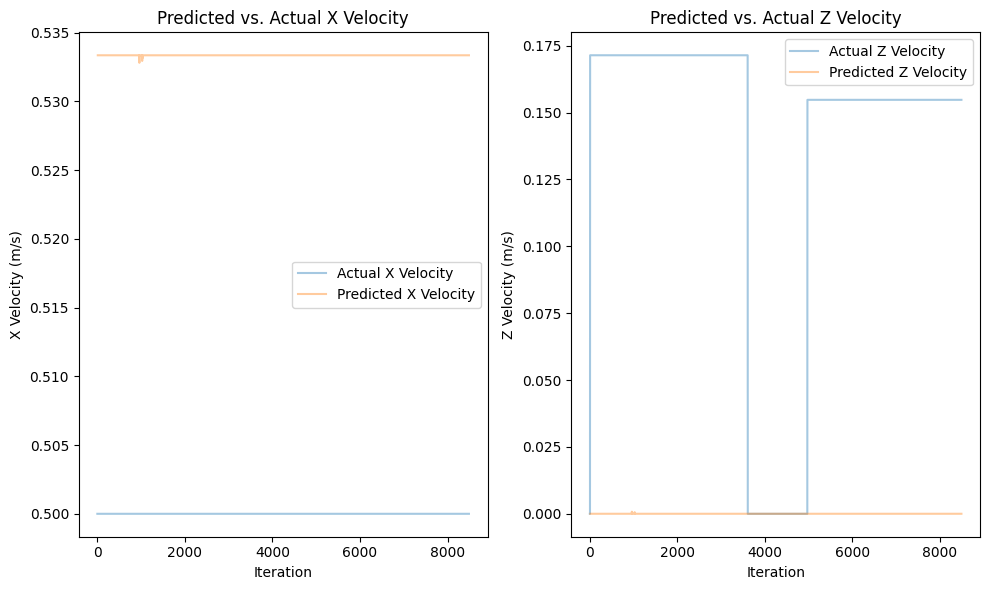

In [15]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot X Velocity subplot
axes[0].plot(combined_df['X_Vel'], label='Actual X Velocity', alpha=0.4)
axes[0].plot(combined_df['X_Vel_Pred_SBack'], label='Predicted X Velocity', alpha=0.4)
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('X Velocity (m/s)')
axes[0].set_title('Predicted vs. Actual X Velocity')
axes[0].legend()

# Plot Z Velocity subplot
axes[1].plot(combined_df['Z_Vel'], label='Actual Z Velocity', alpha=0.4)
axes[1].plot(combined_df['Z_Vel_Pred_SBack'], label='Predicted Z Velocity', alpha=0.4)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Z Velocity (m/s)')
axes[1].set_title('Predicted vs. Actual Z Velocity')
axes[1].legend()

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plot
plt.show()